In [1]:
# Melihat GPU yang tersedia dan penggunaannya.
!nvidia-smi --query-gpu=index,memory.used,memory.total,memory.free,utilization.gpu --format=csv,noheader | awk -F "," 'BEGIN{printf "%-3s \t%7s\t%5s\t%12s\n", "GPU", "Memory", "Free", "RAM"}{printf "%s:\t%6.2f%%\t%7s\t%s\n", $1, ($2/$3)*100, $4, $5}'

GPU 	 Memory	 Free	         RAM
0:	 43.24%	 23007 MiB	 79 %
1:	 90.67%	 3781 MiB	 60 %
2:	 94.83%	 2097 MiB	 0 %
3:	 57.74%	 17131 MiB	 0 %
4:	 55.01%	 18236 MiB	 0 %
5:	  9.82%	 36555 MiB	 100 %
6:	 68.27%	 12864 MiB	 99 %
7:	 57.11%	 17386 MiB	 0 %


In [2]:
# Memilih GPU yang akan digunakan (contohnya: GPU #7)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [3]:
import numpy as np
import fnmatch
import torch
import json
from PIL import Image
import random
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import cv2

seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

NOTE! Installing ujson may make loading annotations faster.


In [4]:
model_name = 'r-cnn'
os.makedirs(model_name, exist_ok=True)

In [5]:
import base64
import io

def img_data_to_pil(img_data):
    f = io.BytesIO()
    f.write(img_data)
    img_pil = Image.open(f)
    return img_pil


def img_data_to_arr(img_data):
    img_pil = img_data_to_pil(img_data)
    img_arr = np.array(img_pil)
    return img_arr


def img_b64_to_arr(img_b64, scale=None):
    img_data = base64.b64decode(img_b64)
    img_arr = img_data_to_arr(img_data)
    
    if scale:
        img_arr = cv2.resize(img_arr, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    return img_arr

In [21]:
class SegmentDataset(torch.utils.data.Dataset):
    def __init__(self, root=None, jsons=None):
        self.jsons = []
        self.transforms = None

        if root:
            for dirpath, dirnames, filenames in os.walk(root):
                for filename in fnmatch.filter(filenames, "*.json"):
                    file_path = os.path.join(dirpath, filename)
                    self.jsons.append(file_path)
        else:
            self.jsons = jsons

    def __getitem__(self, idx):
        file_path = self.jsons[idx]
        boxes = []
        scale = 0.15
        
        with open(file_path, 'r') as f:
            data = json.load(f)
        # Load the image
        image = Image.fromarray(img_b64_to_arr(data['imageData'], scale=scale))
        # Loop through each annotation in the JSON file
        for annotation in data['shapes']:
            # Extract the label and points
            points = annotation['points']

            # Extract the image patch using the points
            (x1, y1), (x2, y2) = annotation['points']
            right = max(x1, x2) * scale
            left = min(x1, x2) * scale
            lower = max(y1, y2) * scale
            upper = min(y1, y2) * scale
            
            boxes.append((left, upper, right, lower))
                        
        num_boxes = len(boxes)
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_boxes,), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_boxes,), dtype=torch.int64)

        image_id = torch.tensor([idx+1])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.jsons)
    
    def transforms(self, transforms):
        self.transforms = transforms

In [22]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [23]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [29]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = SegmentDataset(root='../../Dataset/pegon-ocr-master/Annotations')

# randomly select indices for the train and test sets
n_samples = len(dataset)
train_indices = set(random.sample(range(n_samples), int(n_samples * 0.8)))
test_indices = set(range(n_samples)) - train_indices

# create train and test SegDataset objects
train_dataset = SegmentDataset(jsons=[dataset.jsons[i] for i in train_indices])
train_dataset.transforms = get_transform(train=True)
test_dataset = SegmentDataset(jsons=[dataset.jsons[i] for i in test_indices])
test_dataset.transforms = get_transform(train=False)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

63


In [25]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.01, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/25]  eta: 0:00:36  lr: 0.000426  loss: 2.1526 (2.1526)  loss_classifier: 0.7305 (0.7305)  loss_box_reg: 0.0082 (0.0082)  loss_objectness: 0.6938 (0.6938)  loss_rpn_box_reg: 0.7201 (0.7201)  time: 1.4485  data: 1.1425  max mem: 4663
Epoch: [0]  [10/25]  eta: 0:00:05  lr: 0.004589  loss: 22.6298 (212.4388)  loss_classifier: 3.0598 (71.4707)  loss_box_reg: 7.8467 (123.7030)  loss_objectness: 0.6871 (0.8358)  loss_rpn_box_reg: 1.6088 (16.4293)  time: 0.3901  data: 0.1102  max mem: 5075
Epoch: [0]  [20/25]  eta: 0:00:01  lr: 0.008751  loss: 120.9696 (3594.2218)  loss_classifier: 11.1257 (177.4247)  loss_box_reg: 38.0941 (3188.1069)  loss_objectness: 1.2662 (16.9666)  loss_rpn_box_reg: 32.7056 (211.7235)  time: 0.2708  data: 0.0072  max mem: 5093
Epoch: [0]  [24/25]  eta: 0:00:00  lr: 0.010000  loss: 854.8110 (14054.9840)  loss_classifier: 3.0598 (149.0367)  loss_box_reg: 721.1501 (11951.5076)  loss_objectness: 3.5001 (247.8956)  loss_rpn_box_reg: 57.0646 (1706.5443)  time: 0

Epoch: [3]  [10/25]  eta: 0:00:04  lr: 0.001000  loss: 3568124.0000 (31073827.8153)  loss_classifier: 0.4151 (0.4152)  loss_box_reg: 0.0005 (0.0005)  loss_objectness: 342955.9375 (1407688.5529)  loss_rpn_box_reg: 3012683.0000 (29666138.6371)  time: 0.3139  data: 0.0875  max mem: 5118
Epoch: [3]  [20/25]  eta: 0:00:01  lr: 0.001000  loss: 262709.3438 (17184503.5211)  loss_classifier: 0.4115 (0.4121)  loss_box_reg: 0.0004 (0.0004)  loss_objectness: 28712.4961 (766721.9008)  loss_rpn_box_reg: 227627.1875 (16417781.0728)  time: 0.2283  data: 0.0073  max mem: 5118
Epoch: [3]  [24/25]  eta: 0:00:00  lr: 0.001000  loss: 53421.5312 (14439241.7631)  loss_classifier: 0.4091 (0.4109)  loss_box_reg: 0.0004 (0.0004)  loss_objectness: 19543.0664 (647075.5144)  loss_rpn_box_reg: 38435.7422 (13792165.7240)  time: 0.2242  data: 0.0066  max mem: 5118
Epoch: [3] Total time: 0:00:06 (0.2677 s / it)
creating index...
index created!
Test:  [ 0/13]  eta: 0:00:10  model_time: 0.0574 (0.0574)  evaluator_time: 

Epoch: [6]  [24/25]  eta: 0:00:00  lr: 0.000100  loss: 428.9088 (668.0037)  loss_classifier: 0.3740 (0.3742)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 63.2675 (123.9914)  loss_rpn_box_reg: 365.2670 (543.6380)  time: 0.2276  data: 0.0068  max mem: 5128
Epoch: [6] Total time: 0:00:07 (0.2808 s / it)
creating index...
index created!
Test:  [ 0/13]  eta: 0:00:11  model_time: 0.0694 (0.0694)  evaluator_time: 0.0013 (0.0013)  time: 0.8864  data: 0.8145  max mem: 5128
Test:  [12/13]  eta: 0:00:00  model_time: 0.0629 (0.0548)  evaluator_time: 0.0007 (0.0008)  time: 0.1365  data: 0.0801  max mem: 5128
Test: Total time: 0:00:01 (0.1444 s / it)
Averaged stats: model_time: 0.0629 (0.0548)  evaluator_time: 0.0007 (0.0008)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.00000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.00000
 Average Precision  (AP) @[ IoU=0.75    

In [26]:
import torchvision.transforms as transforms

model.eval()

sample = [train_dataset[5][0].to(device)]
predictions = model(sample)  

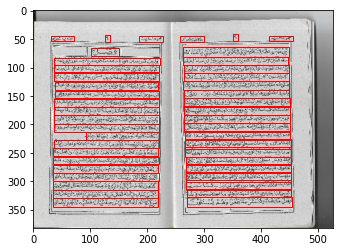

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Transpose the image tensor to the expected shape
img = sample[0].cpu().permute(1, 2, 0)

# Display the image with bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(np.clip(img, 0, 1))  # clip the image to the [0, 1] range
for box in train_dataset[5][1]['boxes'].cpu():
    x1, y1, x2, y2 = box.detach().numpy().tolist()
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

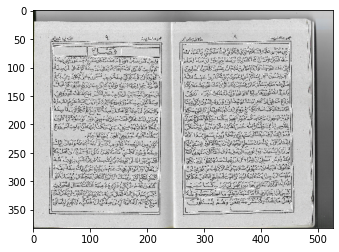

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Display the image with bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(np.clip(img, 0, 1))  # clip the image to the [0, 1] range
for box in predictions[0]['boxes'].cpu():
    x1, y1, x2, y2 = box.detach().numpy().tolist()
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()